<a href="https://colab.research.google.com/github/JR-1991/sysbiojax/blob/master/TestMCMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import sysbiojax
except ImportError:
    !pip install git+https://github.com/JR-1991/sysbiojax.git

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from sysbiojax import Model
from sysbiojax.mcmc import run_mcmc, plot_corner

jax.config.update("jax_enable_x64", True)

/Users/jara1991/anaconda3/envs/jaxlibnew/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Initialize the model
model = Model(name="Simple menten model")

# Add species
model.add_species("s1")

# Add ODEs
model.add_ode("s1", "- (v_max * s1) / ( K_m + s1)")

# Prepare the model for bayes and define priors 
model.parameters.v_max.value = 7.0
model.parameters.v_max.initial_value = 20.0
model.parameters.v_max.lower_bound = 0.01
model.parameters.v_max.upper_bound = 1000.0
model.parameters.v_max.stdev = 8.0


model.parameters.K_m.value = 100.0
model.parameters.K_m.initial_value = 300.0
model.parameters.K_m.lower_bound = 0.01
model.parameters.K_m.upper_bound = 1000.0
model.parameters.K_m.stdev = 200.0

model

Model summary


Eq(x, Matrix([[s1]]))

Eq(theta, Matrix([[v_max, K_m]]))

Eq(Derivative(s1, t), -s1*v_max/(K_m + s1))

,name,symbol,value,initial_value,equation,lower_bound,upper_bound,stdev
0,v_max,v_max,7.0,20.0,None,0.01,1000.0,8.0
1,K_m,K_m,100.0,300.0,None,0.01,1000.0,200.0


In [4]:
# Generate irregular time series data
# from a simple menten model

# Data is sampled at different time points
# and also not at zero to reflect realistic
# scenarios
time = jnp.array([
    [10, 30 ,50 ,70 ,90, 100],
    [15, 35, 55, 78, 98, 108],
    [11, 23, 41 , 68, 86, 110],
    [23, 41, 68, 86, 110, 130],
    [10, 30 ,50 ,70 ,90, 100],
    [15, 35, 55, 78, 98, 108],
    [11, 23, 41 , 68, 86, 110],
    [23, 41, 68, 86, 110, 130],
    [10, 30 ,50 ,70 ,90, 100],
    [15, 35, 55, 78, 98, 108],
    [11, 23, 41 , 68, 86, 110],
    [23, 41, 68, 86, 110, 130],
    [10, 30 ,50 ,70 ,90, 100],
    [15, 35, 55, 78, 98, 108],
    [11, 23, 41 , 68, 86, 110],
    [23, 41, 68, 86, 110, 130],
    [10, 30 ,50 ,70 ,90, 100],
    [15, 35, 55, 78, 98, 108],
    [11, 23, 41 , 68, 86, 110],
    [23, 41, 68, 86, 110, 130],
])

# Set initial conditions above and below the 
# true Km value for the sake of the example
initial_conditions = [
    {"s1": 300.0},
    {"s1": 200.0},
    {"s1": 80.0},
    {"s1": 50.0},
    {"s1": 300.0},
    {"s1": 200.0},
    {"s1": 80.0},
    {"s1": 50.0},
    {"s1": 300.0},
    {"s1": 200.0},
    {"s1": 80.0},
    {"s1": 50.0},
    {"s1": 300.0},
    {"s1": 200.0},
    {"s1": 80.0},
    {"s1": 50.0},
    {"s1": 300.0},
    {"s1": 200.0},
    {"s1": 80.0},
    {"s1": 50.0},
]

time, data = model.simulate(
    initial_conditions=initial_conditions,
    dt0=0.1, saveat=time, in_axes=(0, None, 0)
)

# Add some noise for realism
noisify = lambda x: x + np.random.normal(0, 0.05, size=x.shape)*x
data = np.array([noisify(data[i, :]) for i in range(data.shape[0])])

print(f"Time: {time.shape} | Data: {data.shape}")

Time: (20, 6) | Data: (20, 6, 1)


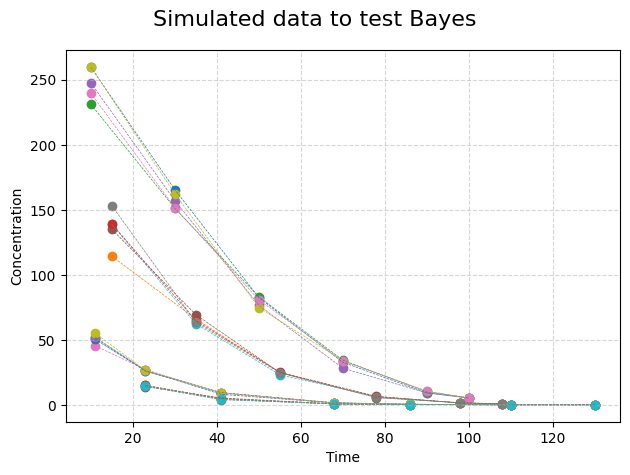

In [5]:
# Visualize generated data
for init in range(0, data.shape[0]):
    plt.scatter(time[init, :], data[init, :, 0])
    plt.plot(time[init, :], data[init, :, 0], linestyle="--", linewidth=.5)
    
    
plt.grid(alpha=0.5, linestyle="--")

plt.xlabel("Time")
plt.ylabel("Concentration")

plt.suptitle("Simulated data to test Bayes", fontsize=16)
plt.tight_layout()

In [6]:
# Perform MCMC simulation
mcmc = run_mcmc(
    model=model,
    data=data,
    initial_conditions=initial_conditions,
    times=time,
    yerrs=0.05,
    num_warmup=3000,
    num_samples=10_000,
    dt0=0.1,
)

<<< Priors >>>


,name,initial_guess,lower_bound,upper_bound,stdev
0,K_m,300.0,0.01,1000.0,200.0
1,v_max,20.0,0.01,1000.0,8.0


<<< Running MCMC >>>


sample: 100%|██████████| 13000/13000 [00:34<00:00, 374.58it/s, 3 steps of size 8.19e-01. acc. prob=0.88] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     sigma      1.41      0.02      1.41      1.37      1.45   9446.99      1.00
  theta[0]     98.71      2.19     98.68     95.16    102.38   9831.06      1.00
  theta[1]      6.97      0.07      6.97      6.86      7.07  10121.14      1.00

Number of divergences: 0


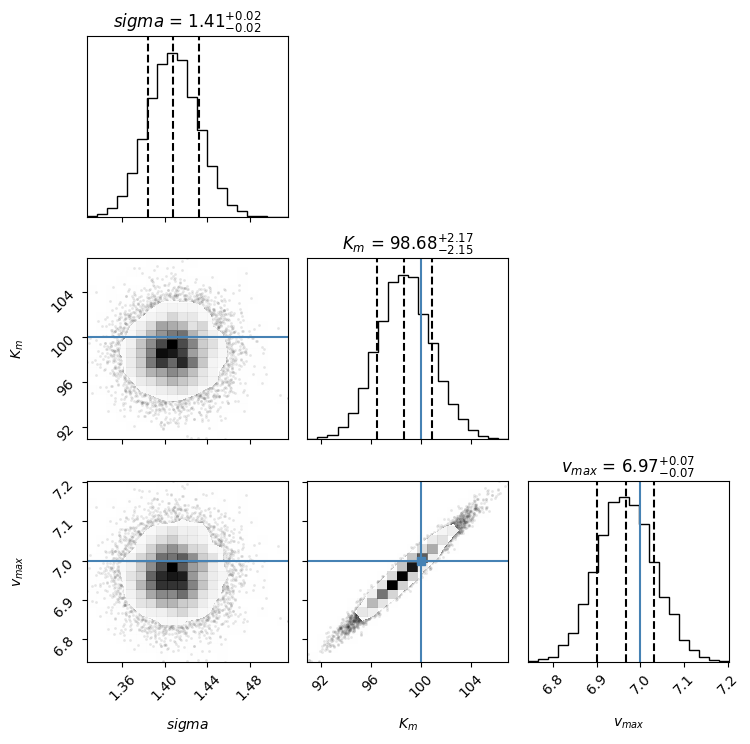

In [7]:
# Visualize the result using a corner plot
# Shows the posterior distribution of the parameters
# Shows the correlation between the parameters
plot_corner(mcmc, model)